Лабораторная работа № 6. Сети Кохонена

Выполнил: Степанов Данила Михайлович

Группа: М8О-407Б-20

Вариант: 22

Цель работы:

Целью работы является исследование свойств слоя Кохонена, карты Кохонена, а также сетей
векторного квантования, обучаемых с учителем, алгоритмов обучения, а также применение сетей
в задачах кластеризации и классификации.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
input_data = [[1.2, 1.1],
              [0.8, 1.2],
              [-1, 0],
              [0.3, 1.2],
              [0.4, -0.4],
              [0.7, 0.9],
              [0.3, -1.3],
              [1.2, -1.4],
              [0, -1.2],
              [-0.4, 0.9],
              [-0.8, 1.1],
              [0.6, -0.4]]

input_data = torch.tensor(input_data)

Часть 1. Слой Кохонена для выполнения кластеризации множества точек. Проверить
качество разбиения.

In [11]:
class KohonenLayer(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.lin = nn.Linear(in_features, out_features)

  def forward(self, x):
      """return default Kohonen outputs and cluster labels for each training sample"""

      w_normj = torch.sum(self.lin.weight ** 2, axis=1)
      w_normj_matrix = torch.reshape(w_normj, (1, self.out_features)).repeat(input_data.shape[0], 1)
      dists = (input_data @ self.lin.weight.T) - 0.5 * w_normj_matrix
      outputs = torch.argmax(dists, dim=1)
      dists[:, :] = 0
      cluster_labels = outputs
      for index, output in enumerate(outputs):
        dists[index, output] = 1
      return dists, cluster_labels

Функция обучения модели

In [12]:
def train(model, X, criterion, optimizer, epochs=10):
  cluster_count = 8
  history = []
  model.train()
  for epoch in range(epochs):
    cluster_groups = [torch.tensor for i in range(cluster_count)]
    optimizer.zero_grad()
    dists, cluster_labels = model(X)
    unique_cluster_labels = np.unique([label.item() for label in cluster_labels.clone().detach().cpu().numpy()])
    cluster_groups = {}
    for cluster in unique_cluster_labels:
      cluster_groups[cluster.item()] = []
    groupby = [cluster_groups[label.item()].append(x) for x, label in zip(X, cluster_labels)]
    result_loss = 0.0
    for cluster in unique_cluster_labels:
      cluster_size = len(cluster_groups[cluster])
      weights = model.lin.weight[cluster, :]
      cluster_centers = weights.repeat(cluster_size)
      cluster_group = torch.flatten(torch.cat(cluster_groups[cluster]), start_dim=0)
      result_loss += criterion(cluster_centers, cluster_group) / 2.
    if epoch % 300 == 0:
      print(f"epoch: {epoch} loss: {result_loss.item()}")
    history.append(result_loss.item())
    result_loss.backward()
    optimizer.step()
  return history

Определение модели, функции потерь и опмимизатора для обучения модели

In [13]:
epochs = 10000

model = KohonenLayer(2, 3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

Обучение модели

In [16]:
history = train(model, input_data, criterion, optimizer, epochs=epochs)

epoch: 0 loss: 0.9549019932746887
epoch: 300 loss: 0.4840148091316223
epoch: 600 loss: 0.29801255464553833
epoch: 900 loss: 0.22624564170837402
epoch: 1200 loss: 0.20125342905521393
epoch: 1500 loss: 0.1938583254814148
epoch: 1800 loss: 0.19211120903491974
epoch: 2100 loss: 0.1917974054813385
epoch: 2400 loss: 0.19175663590431213
epoch: 2700 loss: 0.19175298511981964
epoch: 3000 loss: 0.19175279140472412
epoch: 3300 loss: 0.19175277650356293
epoch: 3600 loss: 0.19175279140472412
epoch: 3900 loss: 0.19175277650356293
epoch: 4200 loss: 0.19175277650356293
epoch: 4500 loss: 0.19175277650356293
epoch: 4800 loss: 0.19175277650356293
epoch: 5100 loss: 0.19175277650356293
epoch: 5400 loss: 0.19175277650356293
epoch: 5700 loss: 0.19175277650356293
epoch: 6000 loss: 0.19175277650356293
epoch: 6300 loss: 0.19175277650356293
epoch: 6600 loss: 0.19175277650356293
epoch: 6900 loss: 0.19175279140472412
epoch: 7200 loss: 0.19175280630588531
epoch: 7500 loss: 0.19175279140472412
epoch: 7800 loss: 0.19

Построение кривой обучения

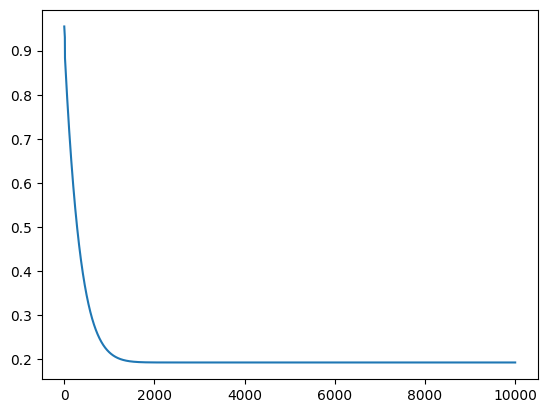

In [17]:
plt.plot(range(epochs), history)

Оценка результата

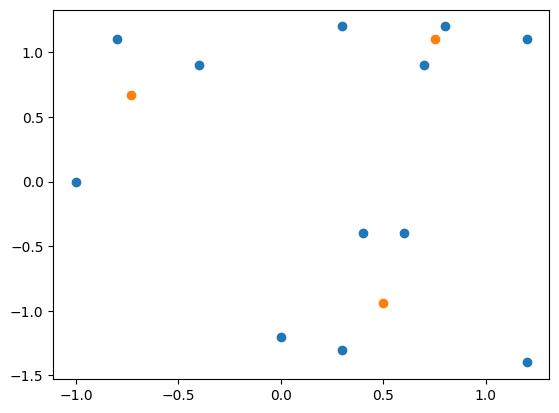

In [18]:
x = [point[0] for point in input_data]
y = [point[1] for point in input_data]

cluster_centers = model.lin.weight.clone().detach().cpu().numpy()
x_points = cluster_centers[:, 0]
y_points = cluster_centers[:, 1]

plt.scatter(x,y)
plt.scatter(x_points, y_points)

Часть 2. Самоогранизующиеся карты Кохонена

In [19]:
import random

Опишем архитектуру самоорганизующейся карты Кохонена

In [20]:
class SOM:
  def __init__(self, in_features, w, h):
    self.in_features = in_features
    self.w = w
    self.h = h
    self.a_t = lambda t: 0.9 * (1 - t / 1000)
    self.sigma_t = lambda t: self.a_t(t)
    self.weights = np.random.randn(w * h, in_features)
    self.h_t = lambda t, i, c: self.a_t(t) * np.exp(-np.sum((i % self.w - c % self.w) ** 2 + (i // self.w - c // self.w) ** 2) / 2 * (self.sigma_t(t)))

  def get_BMU(self, sample):
    n = sample.shape[0]
    size = self.weights.shape[0]
    dists = np.sum((np.repeat(np.reshape(sample, (1, n)), size, axis=0) - self.weights) ** 2, axis=1)
    bmu_index = np.argmin(dists)
    return bmu_index

  def map_error(self, X_train):
    error = 0.0
    for sample in X_train:
      bmu_index = self.get_BMU(sample)
      error += sum((sample - self.weights[bmu_index]) ** 2)
    error = error / X_train.shape[0]
    return error

  def fit(self, X_train, iterations=500):
    for t in range(iterations):
      random_sample_index = np.random.randint(low=0, high=X_train.shape[0])
      bmu_index = self.get_BMU(X_train[random_sample_index])
      h_values = [self.h_t(t, i, bmu_index) for i in range(self.h * self.w)]
      h_values = np.repeat(np.reshape(h_values, (self.w * self.h, 1)), 2, axis=1)
      random_sample = np.repeat(np.reshape(X_train[random_sample_index], (1, 2)), self.h * self.w, axis=0)
      self.weights += h_values * (random_sample - self.weights)
      if t % 100 == 0:
        print(f"iteration #{t} map error: {self.map_error(X_train)}")

Обучим карту Кахонена

In [23]:
input_data = np.array([[1.2, 1.1],
              [0.8, 1.2],
              [-1, 0],
              [0.3, 1.2],
              [0.4, -0.4],
              [0.7, 0.9],
              [0.3, -1.3],
              [1.2, -1.4],
              [0, -1.2],
              [-0.4, 0.9],
              [-0.8, 1.1],
              [0.6, -0.4]])

In [24]:
model = SOM(2, 20, 20)
model.fit(input_data)

iteration #0 map error: 0.010151331977519084
iteration #100 map error: 5.51331490217408e-06
iteration #200 map error: 8.278500442643143e-07
iteration #300 map error: 1.0535489071576062e-06
iteration #400 map error: 5.638585257898545e-08


Оценим результат построения карты Кохонена

In [25]:
weights = model.weights

weights_min = np.min(weights, axis=0)
weights_max = np.max(weights, axis=0)

weights_scaled = ((weights - weights_min) / (weights_max - weights_min)).reshape((model.h, model.w, model.in_features))

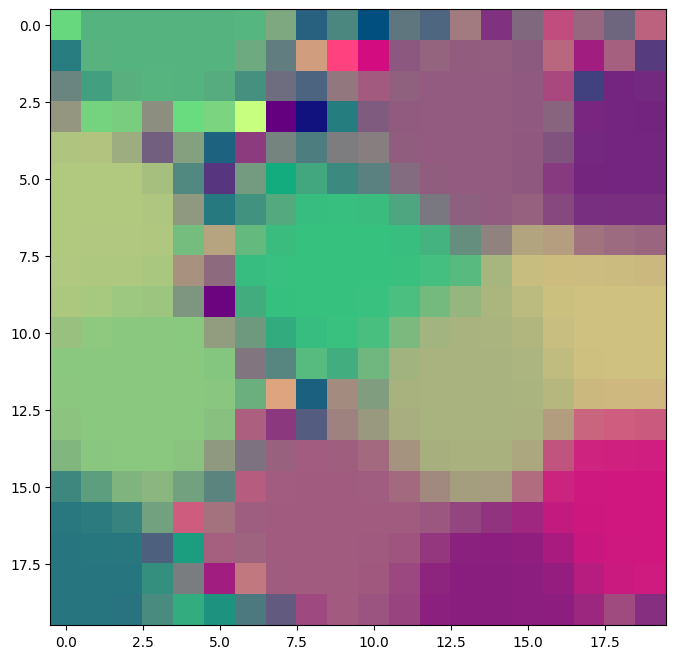

In [26]:
plt.figure(figsize=(15, 8))

plt.imshow(np.insert(weights_scaled, 2, 0.5, axis = 2))

plt.show()

Часть 3. Сеть векторного квантования, обучаемая с учителем

In [27]:
def generate_points(count, a, b):
  X = [random.uniform(-a, a) for i in range(count)]
  points = [(x, (b / a) * (random.randint(0,1)*2-1) * np.sqrt(a ** 2 - x ** 2)) for x in X]
  return points

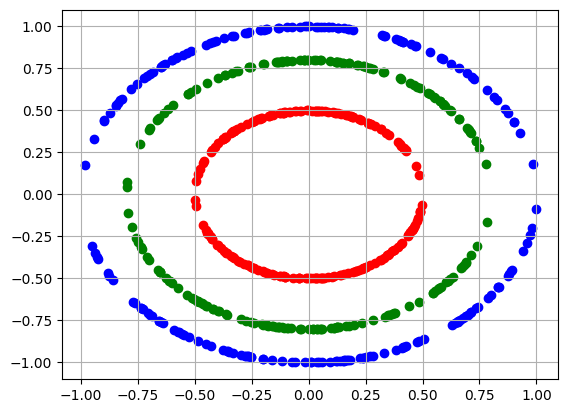

In [28]:
points1 = generate_points(200, 0.5, 0.5)
points2 = generate_points(200, 0.8, 0.8)
points3 = generate_points(200, 1, 1)
x1 = [p[0] for p in points1]
y1 = [p[1] for p in points1]
x2 = [p[0] for p in points2]
y2 = [p[1] for p in points2]
x3 = [p[0] for p in points3]
y3 = [p[1] for p in points3]

plt.scatter(x1, y1, c="red")
plt.scatter(x2, y2, c="green")
plt.scatter(x3, y3, c="blue")
plt.grid(True)

In [29]:
def acc(y_real, y_pred):
  y_real = np.argmax(y_real, axis=1)
  return (np.array(y_real == y_pred)).sum() / y_real.shape[0]

In [41]:
def create_data(size1, size2, size3, tensors=False):
  points1 = generate_points(size1, 0.5, 0.5)
  points2 = generate_points(size2, 0.8, 0.8)
  points3 = generate_points(size3, 1, 1)
  size = size1 + size2 + size3
  labels = np.reshape(np.array([1, 0, 0] * size1 + [0, 1, 0] * size2 + [0, 0, 1] * size3), (size, 3))
  data = np.array(points1 + points2 + points3)
  if tensors:
    return torch.tensor(data, dtype=torch.float), torch.tensor(labels, dtype=torch.float)
  else:
    return data, labels

In [46]:
X, y = create_data(50, 50, 50)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Опишем архитектуру сети векторного квантования, обучаемую с учителем

In [43]:
class LVQNetwork:
  def __init__(self, in_features, k=3, c=3): # k define count of coding vectors for each class, c-count of classes
    self.c = c
    self.k = k
    self.in_features = in_features
    self.a_t = lambda t: 0.1 * (1 - t / 1000)
    self.weights = np.random.randn(c * k, in_features)

  def find_winner(self, sample):
    sample = np.repeat(np.reshape(sample, (1, 2)), self.c * self.k, axis=0)
    dists = np.sqrt(np.sum((sample - self.weights) ** 2, axis=1))
    winner_index = np.argmin(dists)
    return winner_index % self.c

  def init_weights(self, X_train, y_train):
    y_train = np.argmax(y_train, axis=1)
    unique_y = np.unique(y_train)
    samples_groups = [[] for y in unique_y]
    group = [samples_groups[y].append(sample) if len(samples_groups[y]) < self.k else None for sample, y in zip(X_train, y_train)]
    for y in range(len(unique_y)):
      for k in range(self.k):
        self.weights[y * self.c + k, :] = samples_groups[y][k]

  def fit(self, X_train, y_train, iterations=3):
    self.init_weights(X_train, y_train)
    for t in range(iterations):
      for index, train_sample in enumerate(X_train[:90]):
        winner_index = self.find_winner(train_sample)
        if winner_index == np.argmax(y_train[index]): # correct classification, change weights in sample direction
          self.weights[winner_index, :] += self.a_t(t) * (train_sample - self.weights[winner_index, :])
        else: # not correct classification, so change weights in opposite sample direction
          self.weights[winner_index, :] -= self.a_t(t) * (train_sample - self.weights[winner_index, :])


  def predict(self, X_test):
    predictions = np.zeros(X_test.shape[0])
    for index, sample in enumerate(X_test):
      predicted_class = self.find_winner(sample)
      predictions[index] = predicted_class

    return predictions

Обучим модель и оценим результат на тестовом множестве

In [47]:
model = LVQNetwork(2)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print("test acc: ", acc(y_test, predictions))

test acc:  0.4


Вывод:

Сети Кохонена являются достаточно интересным инструментом для решения задач классификации и кластеризации. Карты Кохонена позволяют эффективно кластеризовать точки, создавая целые области на карте с похожими весами. Модели векторного квантования с учителем сложны в настройке, ведь всего за несколько итераций можно сильно изменить опорные векторы так, что они уже не смогут классифицировать объекты. Поэтому нужно думать над тем, что выбрать в качестве опорных векторов, сколько их выбрать, каким взять шаг для обучения. Так, простая сеть обучилась плохо.